# 一维Lax激波管

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/cfd_solver/mindspore_lax_tube.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/cfd_solver/mindspore_lax_tube.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_zh_cn/cfd_solver/lax_tube.ipynb)

## 环境安装

本案例要求 **MindSpore >= 2.0.0** 版本以调用如下接口: *mindspore.jit, mindspore.jit_class, mindspore.data_sink*。具体请查看[MindSpore安装](https://www.mindspore.cn/install)。

此外，你需要安装 **MindFlow >=0.1.0** 版本。如果当前环境还没有安装，请按照下列方式选择后端和版本进行安装。

In [ ]:
mindflow_version = "0.1.0"  # update if needed
# GPU Comment out the following code if you are using NPU.
!pip uninstall -y mindflow-gpu
!pip install mindflow-gpu==$mindflow_version

# NPU Uncomment if needed.
# !pip uninstall -y mindflow-ascend
# !pip install mindflow-ascend==$mindflow_version

## 概述

激波管问题是检验计算流体代码准确性的常见问题。这个案例为一个一维黎曼问题，即理想气体在左右端不同条件下的发展问题。

## 问题描述

Lax激波管问题的定义为:

$$
\frac{\partial}{\partial t} \left(\begin{matrix} \rho \\ \rho u \\ E \\\end{matrix} \right) + \frac{\partial}{\partial x} \left(\begin{matrix} \rho u \\ \rho u^2 + p \\ u(E + p) \\\end{matrix} \right) = 0
$$

$$
E = \frac{\rho}{\gamma - 1} + \frac{1}{2}\rho u^2
$$

其中，对理想气体， $\gamma = 1.4$ ，初始条件为：

$$
\left(\begin{matrix} \rho \\ u \\ p \\\end{matrix}\right)_{x<0.5} = \left(\begin{matrix} 0.445 \\ 0.698 \\ 3.528 \\\end{matrix}\right), \quad
\left(\begin{matrix} \rho \\ u \\ p \\\end{matrix}\right)_{x>0.5} = \left(\begin{matrix} 0.5 \\ 0.0 \\ 0.571 \\\end{matrix}\right)
$$

在激波管两端，施加第二类边界条件。

本案例中`src`包可以在[src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/cfd/lax/src)下载。


In [1]:
from mindspore import context
from mindflow import load_yaml_config, vis_1d
from mindflow import cfd
from mindflow.cfd.runtime import RunTime
from mindflow.cfd.simulator import Simulator

from src.ic import lax_ic_1d

## 设置 MindSpore 运行环境

在运行程序之前，应配置context。`context.set_context`里面常用参数表示如下：

`mode`表示运行的模式，'GRAPH'表示静态图模式, 'PYNATIVE'表示动态图模式，详见[MindSpore 官网](https://www.mindspore.cn/docs/zh-CN/r2.0/design/dynamic_graph_and_static_graph.html)，默认值'GRAPH'；

`save_graphs`表示是否保存计算图，默认值'False'；

`device_target`表示使用的计算平台类型，可以选择'Ascend'或'GPU'，默认值'GPU'；

`device_id`表示使用的计算卡编号，可按照实际情况填写，默认值 0；

In [2]:
context.set_context(mode=context.GRAPH_MODE, save_graphs=False, device_target="GPU", device_id=0)

## 读取配置文件

本程序提供了多种选项来配置网格、材料、仿真时间、边界条件和数值方法。这些配置可以在[numeric.yaml](./numeric.yaml)文件中进行设置。用户可以根据自己的需求选择不同的数值方法。本程序支持以下数值方法：WENO3、WENO5和WENO7三种重构格式，以及Rsuanov、HLLC和Roe三种Riemann求解器。

除了在配置文件中直接进行设置外，还可以通过修改以下代码来选择要使用的数值方法。在下面的代码块中，第二和第三行是设置数值方法的位置。如果希望直接在配置文件中指定数值方法，请将这两行代码注释掉。

In [3]:
config = load_yaml_config('numeric.yaml')
config["space_solver"]["convective_flux"]["reconstructor"] = "WENO5"
config["space_solver"]["convective_flux"]["riemann_computer"] = "Roe"

## 定义Simulator和RunTime

In [4]:
simulator = Simulator(config)
runtime = RunTime(config['runtime'], simulator.mesh_info, simulator.material)

## 初始条件

根据网格坐标确定初始条件。

In [5]:
mesh_x, _, _ = simulator.mesh_info.mesh_xyz()
pri_var = lax_ic_1d(mesh_x)
con_var = cfd.cal_con_var(pri_var, simulator.material)

## 执行仿真

随时间推进执行仿真。

In [6]:
while runtime.time_loop(pri_var):
    pri_var = cfd.cal_pri_var(con_var, simulator.material)
    runtime.compute_timestep(pri_var)
    con_var = simulator.integration_step(con_var, runtime.timestep)
    runtime.advance()

current time = 0.000000, time step = 0.001117
current time = 0.001117, time step = 0.001031
current time = 0.002148, time step = 0.001000
current time = 0.003148, time step = 0.000972
current time = 0.004120, time step = 0.000962
current time = 0.005082, time step = 0.000954
current time = 0.006036, time step = 0.000944
current time = 0.006980, time step = 0.000955
current time = 0.007935, time step = 0.000953
current time = 0.008888, time step = 0.000950
current time = 0.009838, time step = 0.000947
current time = 0.010785, time step = 0.000943
current time = 0.011728, time step = 0.000942
current time = 0.012670, time step = 0.000943
current time = 0.013613, time step = 0.000947
current time = 0.014560, time step = 0.000952
current time = 0.015512, time step = 0.000950
current time = 0.016462, time step = 0.000950
current time = 0.017412, time step = 0.000949
current time = 0.018361, time step = 0.000949
current time = 0.019310, time step = 0.000949
current time = 0.020258, time step

## Post Processing

您可以对密度、压力、速度进行可视化。

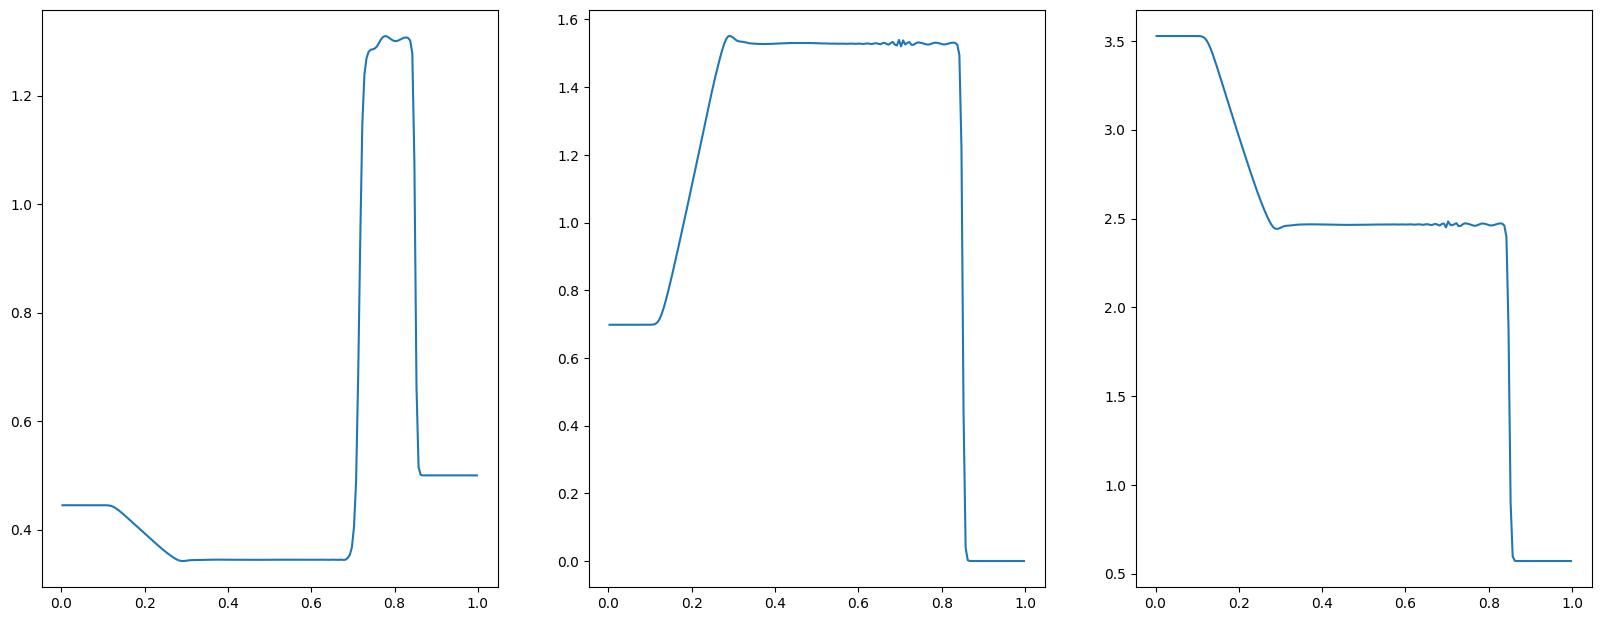

: 

In [7]:
pri_var = cfd.cal_pri_var(con_var, simulator.material)
vis_1d(pri_var, 'lax.jpg')